In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
from ast import literal_eval
import seaborn as sns
from matplotlib_venn import venn3, venn3_unweighted

In [2]:
def HLA_cd8_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace(",", "").replace("'","").split(" ")

def cdr3_lst_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace("'","").split(" ")

def epitope_converter(x):
    #define format of datetime
    return [y for y in x.replace("[","").replace("]","").replace("\n","").split("'") if (y != '') & (y != ' ')]

def peptide_hla_converter(x):
    return re.findall("\w+\s{1}\w{1}\d+", x.replace("[","").replace("]","").replace("\n","").replace("'",""))

def literal_converter(val):
    # replace NaN with '' and perform literal eval on the rest
    return [] if val == '' else literal_eval(val)

converters = {'peptide_HLA_lst': peptide_hla_converter,
              'umi_count_lst_mhc': literal_eval,
              'umi_count_lst_TRA': literal_converter,'umi_count_lst_TRB': literal_converter,
              'cdr3_lst_TRA': cdr3_lst_converter,
              'cdr3_lst_TRB': cdr3_lst_converter,
              'HLA_lst_mhc': cdr3_lst_converter,'HLA_cd8': HLA_cd8_converter} #

# Confusion Plot

## Input

In [3]:
VALID = '../experiments/exp13/run1_archive/cat/eval_clonotypes/valid_ct.csv'

## Load

In [4]:
df = pd.read_csv(VALID, converters=converters)

In [5]:
df['pMHC category'] = np.where(df.multiplets_mhc, 'multiplet','singlet')

In [6]:
#df['TCR category'] = np.where(df.tcr_category == 'unique chains', 'single chains', df.tcr_category)

## Main

In [7]:
matrix = (df.fillna(0).groupby(['pMHC category','tcr_category']).gem.size().to_frame().reset_index()
          .pivot(index='pMHC category', columns='tcr_category', values='gem'))

matrix

tcr_category,missing chain,multiple chains,unique chains
pMHC category,,,
multiplet,1368,273,2428
singlet,1402,148,1492


In [8]:
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})
sns.set_context("paper",font_scale=2)

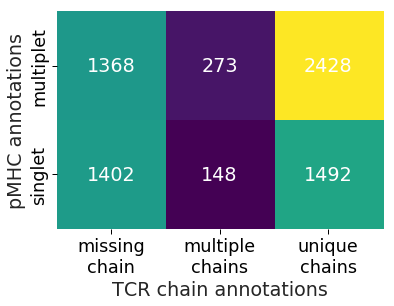

In [16]:
#plt.style.use('ggplot')
mpl.rcParams['axes.grid'] = False

fig, ax = plt.subplots() #figsize=(2.4,3.6) #figsize=(10,10)
im = ax.imshow(matrix, interpolation='nearest', cmap='viridis')

# Loop over data dimensions and create text annotations.
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        text = ax.text(j, i, "%.f" %matrix.iloc[i, j],
                       ha="center", va="center", color="w")

ax.set_xticks(np.arange(matrix.shape[1]))
ax.set_yticks(np.arange(matrix.shape[0]))
       
ax.set_xticklabels(['\n'.join(l.split()) for l in matrix.columns]) #, rotation=40, ha='right' #sorted(df.tcr_category.value_counts().index)
ax.set_yticklabels(matrix.index, rotation=90, va='center') #sorted(df.multiplets_mhc.value_counts().index)
#
# HACK: with matplotlib==3.1.1 the yaxis is cropped..?
ax.set_ylim(sorted((-0.5, matrix.shape[0]-0.5), reverse=True))

sns.despine(left=True,top=True,bottom=True,right=True)

plt.xlabel('TCR chain annotations') #A- and B-c
plt.ylabel('pMHC annotations')
plt.savefig('../experiments/exp13/run1_archive/plt/reports/confusion_multiplets/manual.pdf', bbox_inches='tight')
plt.savefig('../experiments/exp13/run1_archive/plt/reports/confusion_multiplets/manual.png', bbox_inches='tight', dpi=300)
plt.show()

# Venn diagram

## Input

In [6]:
#RAW_DATA = '../experiments/exp13/run1_archive/cat/tables/tcr_barcode.csv'
RAW_DATA = '../experiments/exp13/run3/cat/tables/tcr_barcode.csv'

## Load

In [7]:
df = pd.read_csv(RAW_DATA)

/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: DtypeWarning: Columns (1,4,5,6,7,9,10,11,13,15,17,19,20,21,23,25,27,28,30,31,32,33,34,35,36,37,38,39,42,44,45,49,50,58,59,60,61,62,63,64,65,66,67) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [18]:
gem_tcr = df.dropna(subset=['ct']).gem
gem_mhc = df.dropna(subset=['peptide_HLA']).gem
gem_cd8 = df.dropna(subset=['sample_id']).gem

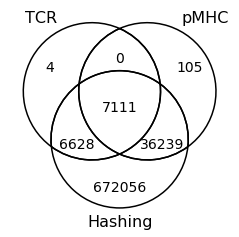

In [54]:
# # Plot
a, b, c = set(gem_tcr), set(gem_mhc), set(gem_cd8)

ab = a.intersection(b)
ac = a.intersection(c)
bc = b.intersection(c)

abc = len(ab.intersection(c))
ab_c = len(ab) - abc
ac_b = len(ac) - abc
bc_a = len(bc) - abc
a_bc = len(a) - ab_c - ac_b - abc
b_ac = len(b) - ab_c - bc_a - abc
c_ab = len(c) - ac_b - bc_a - abc

#### OBS OBS OBS ####
a_bc = 4
#####################

#venn3(subsets = (a_bc, b_ac, ab_c, c_ab, ac_b, bc_a, abc), set_labels = ('TCR', 'pMHC', 'Hashing Ab'))
#title = "GEMs containing TCR, pMHC, and/or Ab BCs"
#plt.title(title)
#plt.savefig(snakemake.output.w, bbox_inches='tight')

v = venn3_unweighted(subsets = (a_bc, b_ac, ab_c, c_ab, ac_b, bc_a, abc),
                     set_labels = ('TCR', 'pMHC', 'Hashing'))
title = "GEMs containing TCR, pMHC, and/or Ab BCs"
#plt.title(title)

v.get_patch_by_id('100').set_color('none')
v.get_patch_by_id('010').set_color('none')
v.get_patch_by_id('110').set_color('none')
v.get_patch_by_id('101').set_color('none')
v.get_patch_by_id('011').set_color('none')
v.get_patch_by_id('001').set_color('none')
v.get_patch_by_id('111').set_color('none')

v.get_patch_by_id('100').set_edgecolor('black')
v.get_patch_by_id('010').set_edgecolor('black')
v.get_patch_by_id('110').set_edgecolor('black')
v.get_patch_by_id('101').set_edgecolor('black')
v.get_patch_by_id('011').set_edgecolor('black')
v.get_patch_by_id('001').set_edgecolor('black')
v.get_patch_by_id('111').set_edgecolor('black')
v.get_patch_by_id('111').set_edgecolor('black')

v.get_patch_by_id('100').set_alpha(1)
v.get_patch_by_id('010').set_alpha(1)
v.get_patch_by_id('110').set_alpha(1)
v.get_patch_by_id('101').set_alpha(1)
v.get_patch_by_id('011').set_alpha(1)
v.get_patch_by_id('001').set_alpha(1)
v.get_patch_by_id('111').set_alpha(1)

v.get_patch_by_id('100').set_lw(1.5)
v.get_patch_by_id('010').set_lw(1.5)
v.get_patch_by_id('110').set_lw(1.5)
v.get_patch_by_id('101').set_lw(1.5)
v.get_patch_by_id('011').set_lw(1.5)
v.get_patch_by_id('001').set_lw(1.5)
v.get_patch_by_id('111').set_lw(1.5)

for text in v.set_labels:
    text.set_fontsize(16)

for text in v.subset_labels:
    text.set_fontsize(14)
    
#Move the numbers in the circles  
pos = v.get_label_by_id("101").get_position()
v.get_label_by_id("101").set_position((pos[0], -0.23))
pos = v.get_label_by_id("011").get_position()
v.get_label_by_id("011").set_position((pos[0], -0.23))

#plt.savefig('../experiments/exp13/run1_archive/plt/venn/TCR_MHC_AB.manual.pdf', bbox_inches='tight')
#plt.savefig('../experiments/exp13/run1_archive/plt/venn/TCR_MHC_AB.manual.png', bbox_inches='tight', dpi=300)

In [27]:
x = v.get_label_by_id("100")
dir(x)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_animated',
 '_axes',
 '_bbox_patch',
 '_cached',
 '_clipon',
 '_clippath',
 '_color',
 '_contains',
 '_draw_bbox',
 '_fontproperties',
 '_get_dist_to_box',
 '_get_layout',
 '_get_multialignment',
 '_get_rendered_text_width',
 '_get_wrap_line_width',
 '_get_wrapped_text',
 '_get_xy_display',
 '_gid',
 '_horizontalalignment',
 '_in_layout',
 '_label',
 '_linespacing',
 '_mouseover',
 '_multialignment',
 '_oid',
 '_path_effects',
 '_picker',
 '_prop_order',
 '_propobservers',
 '_rasterized',
 '_remove_method',
 '_renderer',
 '_rotation',
 '_rotation_mode',
 '_set_g

# Plot distribution of hashing UMI

In [8]:
sum(df.label == 1)

7255

In [9]:
sum(df.label != 1)

714884

In [10]:
#df = df[df.label == 1].copy()

In [11]:
df['hashing_category'] = np.where(df.ct.isna(), 'TCR-void','TCR-occupied')

In [12]:
tmp = df.groupby('hashing_category').umi_count_cd8.apply(list).to_frame().T
tmp

hashing_category,TCR-occupied,TCR-void
umi_count_cd8,"[2059.0, 838.0, 4134.0, 6479.0, 1234.0, 1514.0...","[2.0, 24.0, 20.0, 7.0, 18.0, 23.0, 1.0, 958.0,..."


In [13]:
tmp_o = tmp['TCR-occupied'].explode().to_frame().reset_index(drop=True)
tmp_o['var'] = 'TCR-occupied\nGEMs'
tmp_o.rename(columns={'TCR-occupied':'UMI'}, inplace=True)
tmp_o

,UMI,var
0,2059.0,TCR-occupied\nGEMs
1,838.0,TCR-occupied\nGEMs
2,4134.0,TCR-occupied\nGEMs
3,6479.0,TCR-occupied\nGEMs
4,1234.0,TCR-occupied\nGEMs
...,...,...
13764,19.0,TCR-occupied\nGEMs
13765,7070.0,TCR-occupied\nGEMs
13766,36.0,TCR-occupied\nGEMs
13767,24.0,TCR-occupied\nGEMs


In [14]:
tmp_v = tmp['TCR-void'].explode().to_frame().reset_index(drop=True)
tmp_v['var'] = 'TCR-void\nGEMs'
tmp_v.rename(columns={'TCR-void':'UMI'}, inplace=True)
tmp_v

,UMI,var
0,2.0,TCR-void\nGEMs
1,24.0,TCR-void\nGEMs
2,20.0,TCR-void\nGEMs
3,7.0,TCR-void\nGEMs
4,18.0,TCR-void\nGEMs
...,...,...
708365,5.0,TCR-void\nGEMs
708366,35.0,TCR-void\nGEMs
708367,3.0,TCR-void\nGEMs
708368,16.0,TCR-void\nGEMs


In [15]:
plt_df = pd.concat([tmp_o, tmp_v], ignore_index=True)
plt_df.UMI = plt_df.UMI.astype(float)
plt_df

,UMI,var
0,2059.0,TCR-occupied\nGEMs
1,838.0,TCR-occupied\nGEMs
2,4134.0,TCR-occupied\nGEMs
3,6479.0,TCR-occupied\nGEMs
4,1234.0,TCR-occupied\nGEMs
...,...,...
722134,5.0,TCR-void\nGEMs
722135,35.0,TCR-void\nGEMs
722136,3.0,TCR-void\nGEMs
722137,16.0,TCR-void\nGEMs


In [16]:
#plt_df.umi_mod = np.where(plt_df.UMI > )

In [17]:
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})
rc = {"font.size":12,
      "axes.labelsize":12,
      "axes.titlesize":14,
      "xtick.labelsize":10,
      "ytick.labelsize":10,
      "legend.fontsize":10,
      "legend.title_fontsize":12}
sns.set_context("paper",font_scale=2)

(-2193.25, 46080.25)


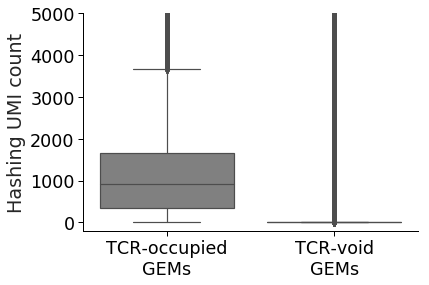

In [20]:
#fig = plt.figure(figsize=(3.6,2.4))
ax = sns.boxplot(data=plt_df, y='UMI',x='var', palette=['grey'])
print(ax.get_ylim())
plt.ylim(-200, 5000)
plt.xlabel('')
plt.ylabel('Hashing UMI count')
sns.despine()
# #plt.savefig('../experiments/exp13/run1_archive/plt/reports/hashing_umi_dist.png',bbox_inches='tight', dpi=300)
# #plt.savefig('../experiments/exp13/run1_archive/plt/reports/hashing_umi_dist.pdf',bbox_inches='tight')
plt.savefig('../experiments/exp13/run3/plt/venn/hashing_umi_dist.png',bbox_inches='tight', dpi=300)
# #plt.savefig('../experiments/exp13/run3/plt/venn/hashing_umi_dist.pdf',bbox_inches='tight')

In [21]:
from scipy.stats import wilcoxon

In [25]:
from scipy.stats import mannwhitneyu
u, p = mannwhitneyu(tmp_o.UMI, tmp_v.UMI) #, alternative='greater'

In [26]:
u

243042947.5

In [27]:
p

0.0